In [25]:
import netCDF4 as nc 
# miscellaneous operating system interfaces
import os

# visualizes the data
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

#processes the data
import numpy as np 
import pandas as pd

# helps visualize the data
import cartopy.crs as ccrs 
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.feature import BORDERS, COASTLINE


from matplotlib.colors import TwoSlopeNorm

import geopandas as gpd
from shapely.geometry import Point

from sklearn.decomposition import PCA

In [26]:
# LOAD DATA
file_path = '../../Data/GRCTellus.JPL.200204_202411.GLO.RL06.3M.MSCNv04CRI.nc'
#file_path = '../../Data/JPL_Mascons.nc' 

# Check if the file exists
if os.path.exists(file_path):
    mascons = nc.Dataset(file_path)
else:
    raise FileNotFoundError(f"File not found: {file_path}")

In [27]:
# try to reformat time into months
from datetime import datetime, timedelta

# Extract necessary variables
time_data = mascons.variables['time'][:]  # Time in days since 2002-01-01T00:00:00Z
lwe_thickness = mascons.variables['lwe_thickness'][:]  # Shape (239, 360, 720)
only_land_mask = np.array(mascons["lwe_thickness"]) * np.array(mascons["land_mask"]) # Shape (360, 720)
print(only_land_mask.shape)

# Step 1: Convert time to datetime
start_date = datetime(2002, 1, 1)
time_dates = np.array([start_date + timedelta(days=int(t)) for t in time_data])

# Step 2: Create a pandas DataFrame for grouping
time_df = pd.DataFrame({'time': time_dates})
time_df['year_month'] = time_df['time'].dt.to_period('M')  # Convert to 'YYYY-MM' format for grouping

(239, 360, 720)


In [28]:
def Convert_2002_2_DMJ(days, unit=mascons['time'].units):
    """
    Convert days since 2002-04-01 to date-month-year format.
    
    Parameters:
    -----------
    days : array-like
        Days since 2002-04-01
    unit : str
        Unit of the time, e.g. 'days', 'months', 'years'
    
    Returns:
    --------
    date : array-like
        Date in date-month-year format
    """
    
    # Convert days to datetime64
    date = nc.num2date(days, unit, only_use_cftime_datetimes=False, only_use_python_datetimes=False)

    if isinstance(date, np.ndarray):
        date = [datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in date]
    else:
        date = datetime(date.year, date.month, date.day, date.hour, date.minute, date.second)


    return date

In [29]:
def plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index=None):
    """
    Plots the LWE thickness for a specific region defined by center latitude, center longitude,
    width, and height in degrees, applying a landmask.

    Parameters:
        center_lat (float): Center latitude of the region.
        center_lon (float): Center longitude of the region.
        width (float): Width of the region in degrees.
        height (float): Height of the region in degrees.
        time_index (int, optional): Index of the time step to plot. If None, defaults to the global variable i.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    # Adjust center_lon to match the dataset's range (0 to 360)
    if center_lon < 0:
        center_lon += 360

    # Calculate the bounds of the region
    lat_min = max(center_lat - height / 2, 45) #45 N as a treshold to get the right frame for canada
    lat_max = min(center_lat + height / 2, 70) #70 N as a threshold to get the right frame to not get nunavut
    lon_min = center_lon - width / 2
    lon_max = center_lon + width / 2

    # Filter the latitude and longitude indices
    lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
    lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]

    # Check if indices are valid
    if len(lat_indices) == 0 or len(lon_indices) == 0:
        print("No data available for the specified region.")
        return

    # Extract the subset of data
    subset_lat = lat[lat_indices]
    subset_lon = lon[lon_indices]
    time_idx = time_index if time_index is not None else i
    subset_lwe_thickness = only_land_mask[time_idx, lat_indices[:, None], lon_indices] #changed this to only_land_mask could be also lwe_thickness

    # Check if subset_lwe_thickness is valid
    if subset_lwe_thickness.size == 0:
        print("No LWE thickness data available for the specified region.")
        return

    # Create a figure and axis with a Cartopy projection
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Define a normalization that centers the colorbar at 0
    data_min = subset_lwe_thickness.min()
    data_max = subset_lwe_thickness.max()
    data_min=-data_max
    if data_min < 0 and data_max > 0:
        norm = TwoSlopeNorm(vmin=data_min, vcenter=0, vmax=data_max)
    else:
        norm = plt.Normalize(vmin=data_min, vmax=data_max)

    # Plot the lwe_thickness for the specified time step with the defined normalization
    lwe_plot = ax.pcolormesh(subset_lon, subset_lat, subset_lwe_thickness, 
                             cmap='seismic', norm=norm, transform=ccrs.PlateCarree())

    # Add coastlines, borders, and gridlines
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax.gridlines(draw_labels=True)

    # Add a colorbar
    cbar = plt.colorbar(lwe_plot, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Liquid Water Equivalent Thickness')

    # Set the colorbar ticks and range
    #cbar.set_ticks(np.linspace(data_min, data_max, num=5))  # 5 evenly spaced ticks
    #cbar.ax.tick_params(labelsize=10)  # Adjust tick label size

    # Set the title
    ax.set_title(f'LWE Thickness for {Convert_2002_2_DMJ(time_index, unit=mascons["time"].units).strftime("%Y-%m-%d")} in Region ({center_lat}, {center_lon})')
    
    return fig, data_min, data_max



data_min -237.644336204148
data_max 237.644336204148


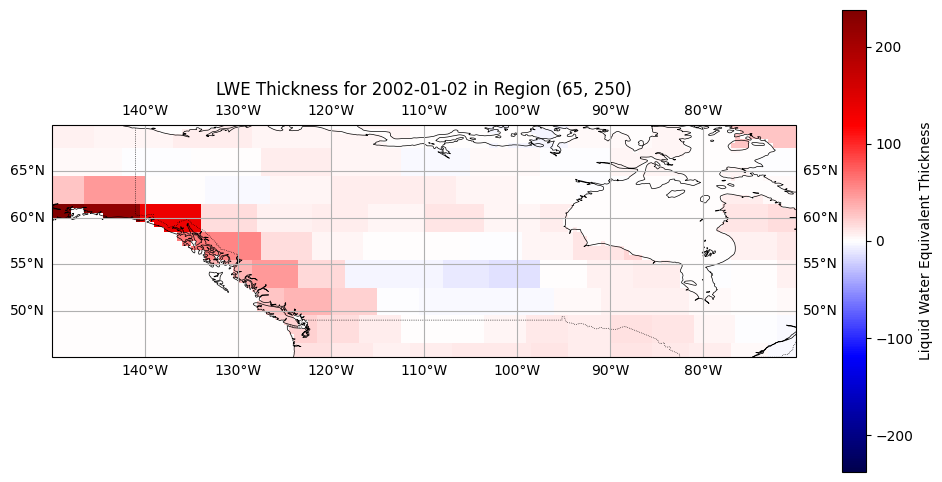

In [30]:
# Plotting the LWE thickness with landmask for canada
# Set the right rectangle parameters for canada
center_lat = 65
center_lon = -110
width = 80
height = 40
time_index = 1

lat = mascons.variables['lat'][:]
lon = mascons.variables['lon'][:]
lwe_thickness = mascons.variables['lwe_thickness'][:]

fig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)
print("data_min", data_min)
print("data_max", data_max)
# Show the plot
plt.show()

#### Starting with the EOF of Canada

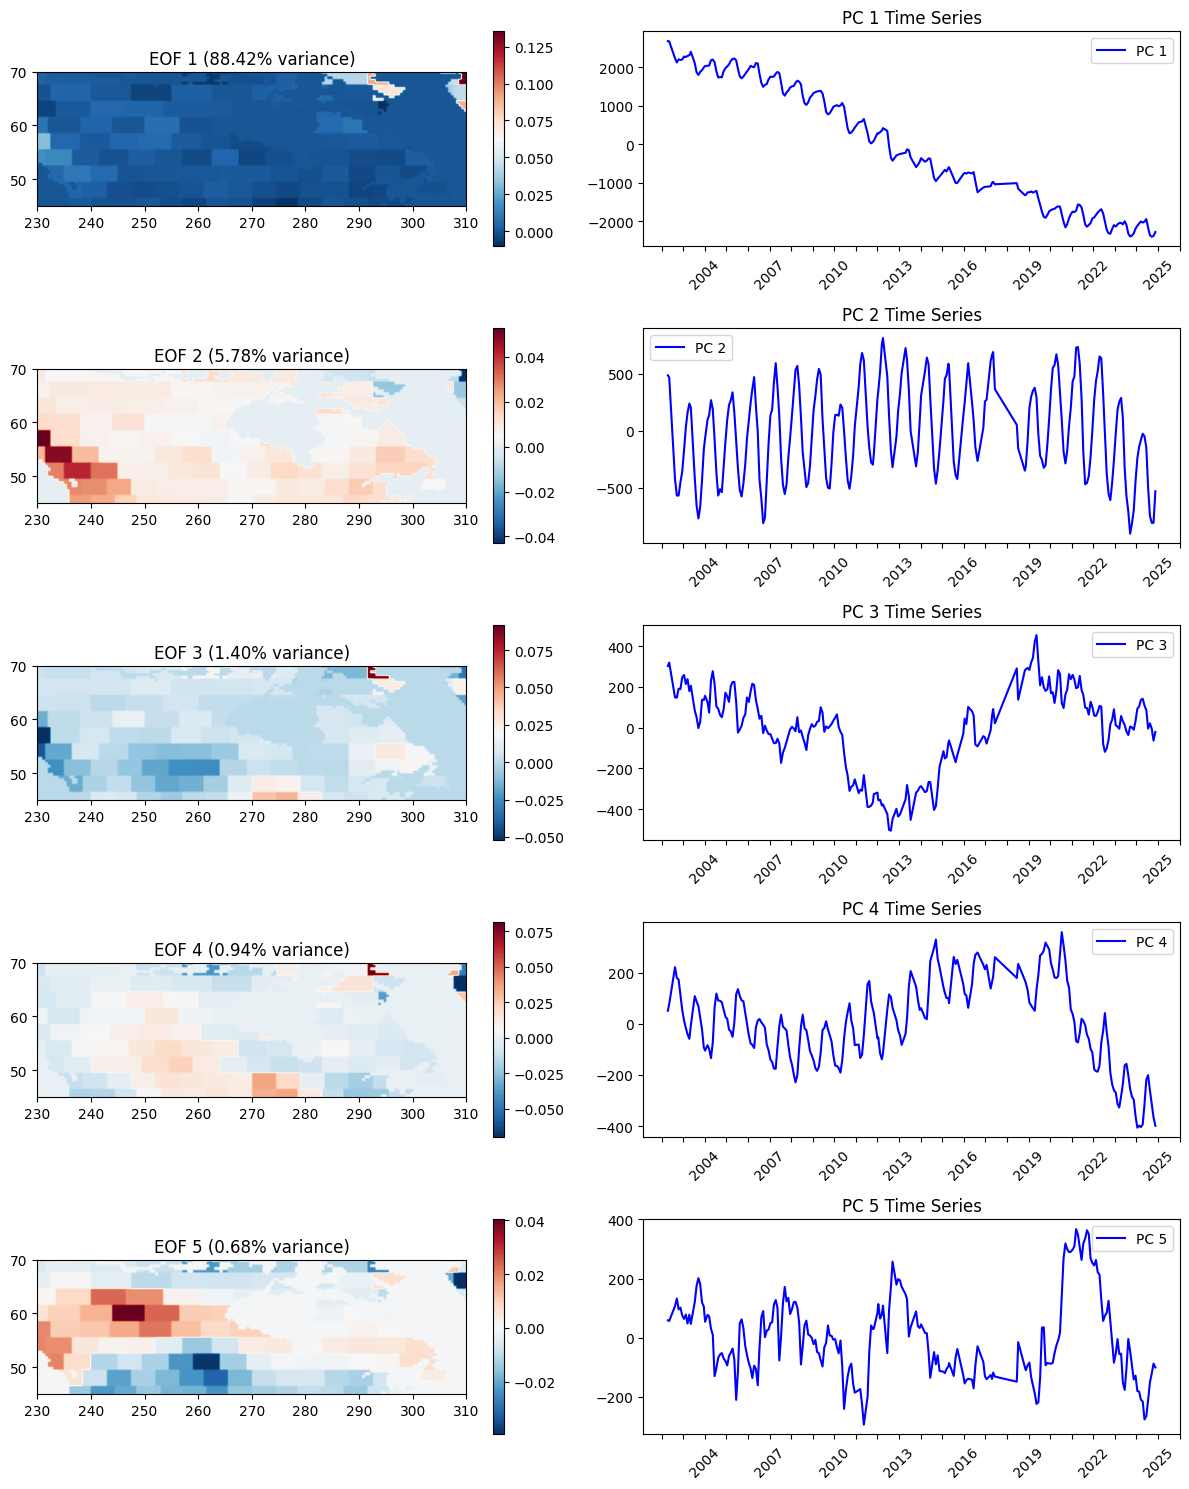

In [31]:
# Define the region of interest
center_lat = 60
center_lon = -90
width = 80
height = 40

# Adjust center_lon to match the dataset's range (0 to 360)
if center_lon < 0:
    center_lon += 360

# Calculate the bounds of the region
lat_min = max(center_lat - height / 2, 45)  # Ensure latitude is not below 45°N
lat_max = min(center_lat + height / 2, 70)  # Ensure latitude is not above 70°N
lon_min = center_lon - width / 2
lon_max = center_lon + width / 2

# Filter the latitude and longitude indices
lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[0]

# Check if indices are valid
if len(lat_indices) == 0 or len(lon_indices) == 0:
    raise ValueError("No data available for the specified region.")

# Extract the subset of data
subset_lat = lat[lat_indices]
subset_lon = lon[lon_indices]
subset_data = only_land_mask[:, lat_indices[:, None], lon_indices]  # Shape: (time, lat, lon)

# Flatten spatial dimensions for PCA
num_time_steps = subset_data.shape[0]
num_lat = len(lat_indices)
num_lon = len(lon_indices)
reshape_data = subset_data.reshape(num_time_steps, num_lat * num_lon)

# Remove time mean to compute anomalies (centering the data)
column_time_mean = np.mean(reshape_data, axis=0, keepdims=True)
data_centered = reshape_data - column_time_mean

# Perform PCA
pca = PCA(n_components=5)
pca.fit(data_centered)
transformed_data = pca.transform(data_centered)
explained_variance = pca.explained_variance_ratio_

# Visualize the EOFs and their time series
fig, axes = plt.subplots(5, 2, figsize=(12, 15))  # Adjust as needed
for i in range(5):  # Plot first 5 EOFs and their time series
    # EOF spatial pattern
    eof_pattern = pca.components_[i].reshape(num_lat, num_lon)
    im = axes[i, 0].imshow(eof_pattern, cmap='RdBu_r', origin='lower',
                           extent=[lon_min, lon_max, lat_min, lat_max])
    axes[i, 0].set_title(f'EOF {i+1} ({explained_variance[i]*100:.2f}% variance)')
    fig.colorbar(im, ax=axes[i, 0])

    # Principal component time series
    axes[i, 1].plot(time_dates, transformed_data[:, i], label=f'PC {i+1}', color='b')  # Use time_dates for x-axis
    axes[i, 1].set_title(f'PC {i+1} Time Series')
    axes[i, 1].legend()

    # Set ticks every year
    axes[i, 1].xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year

    # Format labels to show the year only every 3 years
    def custom_year_formatter(x, pos):
        year = mdates.num2date(x).year
        return str(year) if year % 3 == 0 else ''  # Show year only if divisible by 3

    axes[i, 1].xaxis.set_major_formatter(FuncFormatter(custom_year_formatter))

    # Rotate the tick labels for better readability
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [32]:
def gap_detection(timestamps: np.array) -> np.array:
    """
    Detect missing timestamps in a time series.
    Parameters:
    -----------
    timestamps : array-like
        Timestamps of the data  
    
    Returns:
    missing timestamps"""

    # Convert numeric timestamps to datetime objects
    dates = Convert_2002_2_DMJ(timestamps)
    dates = [pd.to_datetime(d.strftime('%Y-%m')) for d in dates]
    dates = pd.DatetimeIndex(dates)
    
    min_date = dates.min()
    max_date = dates.max()
    all_dates = pd.date_range(start=min_date, end=max_date, freq='M')
    #transform all dates to the Y%-M% format
    all_dates = [pd.to_datetime(d.strftime('%Y-%m')) for d in all_dates]
    missing_dates = np.setdiff1d(all_dates, dates)


    return missing_dates

Original number of time steps: 239
Length after converting to monthly periods: 239
Length after finding unique monthly periods: 237
Number of time steps to keep (first occurrences): 237

Months appearing more than once in time_dates:
2012-01    2
2015-04    2
Freq: M, Name: count, dtype: int64
Keeping only the first measurement for these months.
Length of filtered time_dates: 237
Length of original_dates_dtindex (unique months): 237
Identified 35 missing months.
Shape of filtered transformed_data: (237, 5)
Shape of pc_df: (237, 5)
Shape of reconstructed data for missing months: (35, 50, 160)
Shape of filtered original spatial data: (237, 50, 160)
Shape of final combined data array: (272, 50, 160)
Number of time steps in final array: 272


/var/folders/y7/dv79l4qx6hl922vv5hjh19dc0000gn/T/ipykernel_50492/3103768843.py:197: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pc_df_interpolated.index, pc_df_interpolated[0], '.-', label='Interpolated PC1 Line', alpha=0.7, markersize=3, linestyle='--', color='grey')


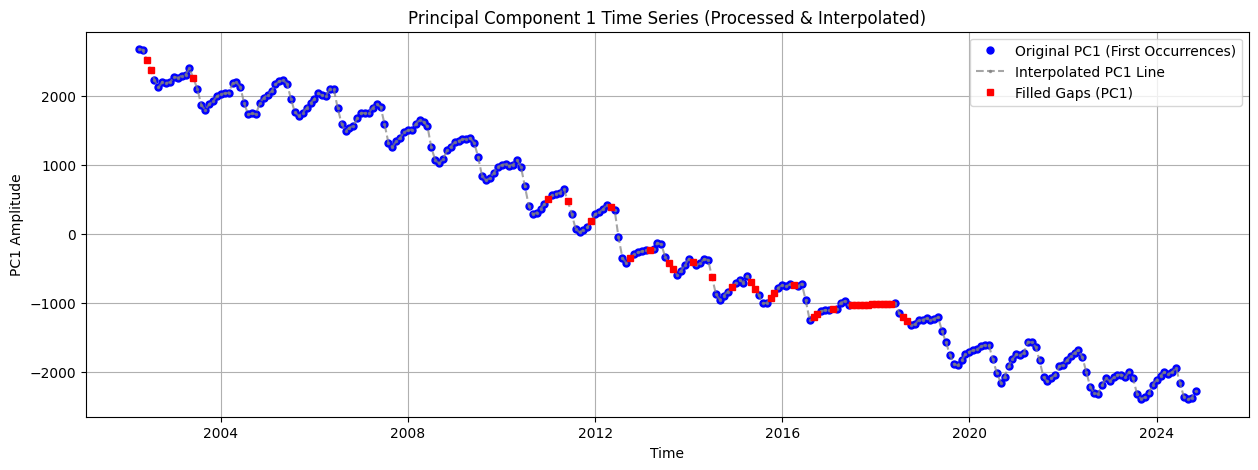

/var/folders/y7/dv79l4qx6hl922vv5hjh19dc0000gn/T/ipykernel_50492/3103768843.py:220: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pc_df_interpolated.index, pc_df_interpolated[1], '.-', label='Interpolated PC2 Line', alpha=0.7, markersize=3, linestyle='--', color='grey')


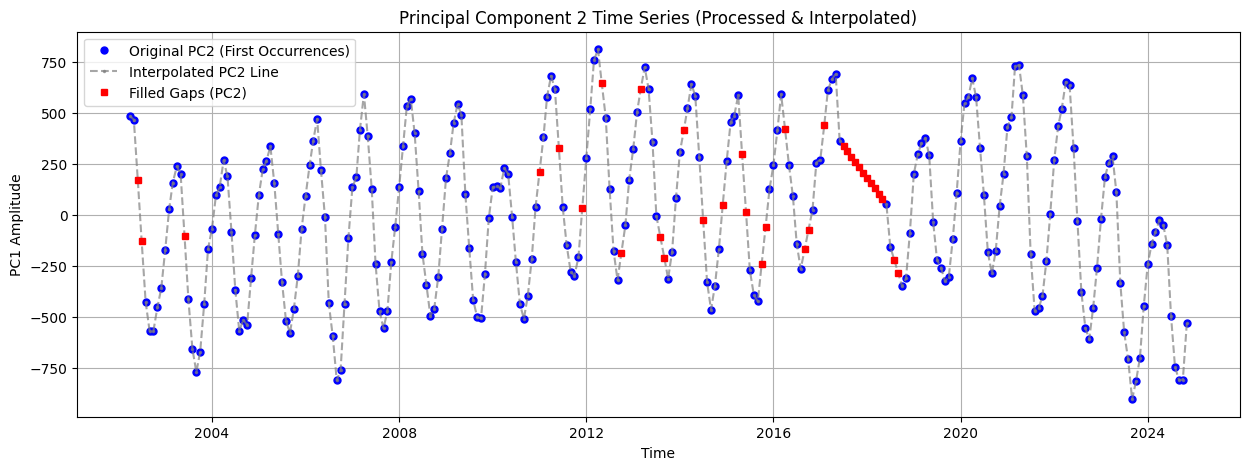

/var/folders/y7/dv79l4qx6hl922vv5hjh19dc0000gn/T/ipykernel_50492/3103768843.py:245: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(pc_df_interpolated.index, pc_df_interpolated[2], '.-', label='Interpolated PC3 Line', alpha=0.7, markersize=3, linestyle='--', color='grey')


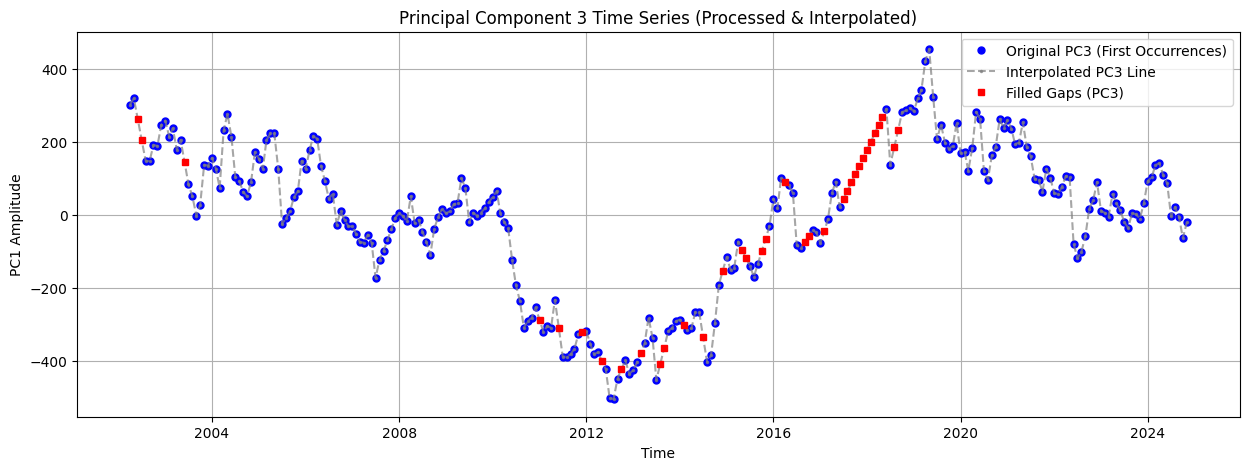

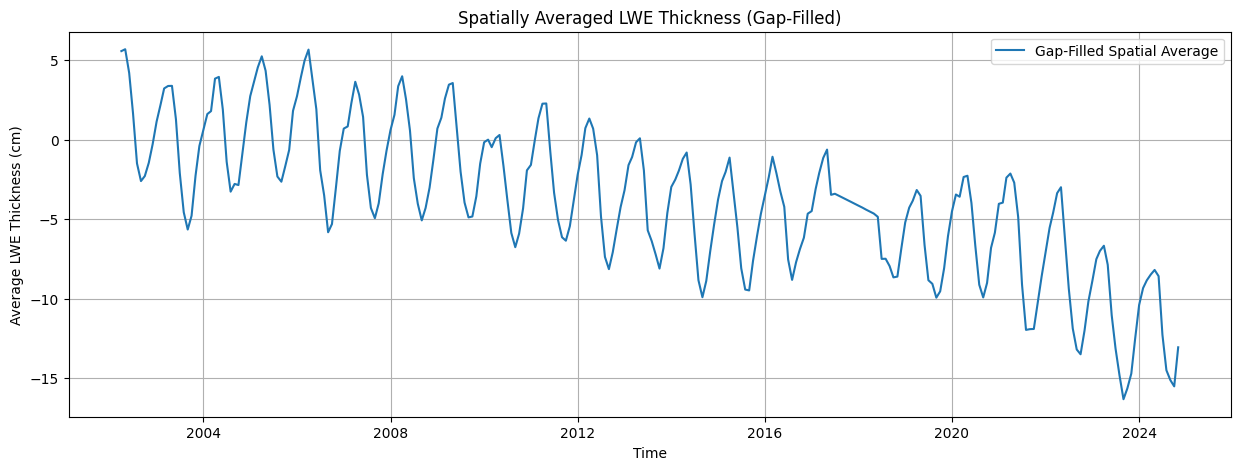

In [33]:
# %% IMPORTS FOR INTERPOLATION
import pandas as pd
# from scipy.interpolate import interp1d # Not strictly needed if using pandas interpolate
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# %% ==== GAP DETECTION, DUPLICATE HANDLING, and INTERPOLATION ====

# 1. Identify Duplicates and Missing Dates
print("Original number of time steps:", len(time_dates))

# Convert to pandas Series and then to monthly periods
time_periods = pd.Series(time_dates).dt.to_period('M')
print(f"Length after converting to monthly periods: {len(time_periods)}") # Should be 239

# Find unique periods
unique_time_periods = time_periods.unique()
print(f"Length after finding unique monthly periods: {len(unique_time_periods)}") # Should be 237

# --- Handle Duplicates ---
# Create a boolean mask to keep only the *first* occurrence of each month
keep_mask = ~time_periods.duplicated(keep='first')
print(f"Number of time steps to keep (first occurrences): {keep_mask.sum()}") # Should be 237

if len(time_periods) != len(unique_time_periods):
    duplicated_months_counts = time_periods[time_periods.duplicated(keep=False)].sort_values().value_counts()
    print("\nMonths appearing more than once in time_dates:")
    print(duplicated_months_counts)
    print("Keeping only the first measurement for these months.")
else:
    print("\nNo duplicate months found in time_dates.")

# Filter the original time_dates to match the 'keep_mask'
# These are the dates corresponding to the data we will use
time_dates_filtered = time_dates[keep_mask]
print(f"Length of filtered time_dates: {len(time_dates_filtered)}") # Should be 237

# Use these filtered dates to create the base DatetimeIndex for existing data
# Convert Periods to Timestamps for indexing
original_dates_dtindex = pd.PeriodIndex(time_periods[keep_mask].sort_values(), freq='M').to_timestamp()
# Ensure it has the correct length
print(f"Length of original_dates_dtindex (unique months): {len(original_dates_dtindex)}") # Should be 237


# --- Find Missing Dates ---
# Create the full expected monthly date range based on the unique months identified
full_date_range = pd.date_range(start=original_dates_dtindex.min(),
                                end=original_dates_dtindex.max(),
                                freq='MS') # 'MS' for Month Start frequency

# Find the missing dates by comparing the full range to the unique dates we have data for
missing_dates = full_date_range.difference(original_dates_dtindex)

print(f"Identified {len(missing_dates)} missing months.")
# print("Missing dates:", missing_dates) # Uncomment to see the list


# 2. Prepare Principal Components for Interpolation (Using Filtered Data)
# Filter the PCA results (transformed_data) using the same 'keep_mask'
# This ensures we only use the PC values corresponding to the first occurrence of each month
transformed_data_filtered = transformed_data[keep_mask]
print(f"Shape of filtered transformed_data: {transformed_data_filtered.shape}") # Should be (237, 5)

# Create the DataFrame using the FILTERED data and the corresponding unique monthly index
# Sort the index first to ensure proper alignment if filtering changed order (though mask should preserve it)
# pc_df = pd.DataFrame(data=transformed_data_filtered, index=original_dates_dtindex) # original_dates_dtindex is already sorted
pc_df = pd.DataFrame(data=transformed_data_filtered, index=pd.to_datetime(time_dates_filtered))
pc_df = pc_df.resample('MS').mean() # Ensure one value per month start, handles the index conversion


# Align the pc_df index with the unique monthly index we derived earlier
pc_df = pc_df.reindex(original_dates_dtindex)


print(f"Shape of pc_df: {pc_df.shape}") # Should be (237, 5)
# print("PC DataFrame head:\n", pc_df.head())


# 3. Reindex to Full Time Range and Interpolate
# Reindex the DataFrame with the full date range, introducing NaNs for missing dates
pc_df_full = pc_df.reindex(full_date_range)

# Interpolate the missing values (NaNs) in the PC time series
pc_df_interpolated = pc_df_full.interpolate(method='linear', axis=0) # Interpolate along time axis

# Check if any NaNs remain
if pc_df_interpolated.isnull().values.any():
     print("Warning: NaNs remaining after interpolation. Check start/end points.")
# print("NaNs remaining after interpolation:", pc_df_interpolated.isnull().sum().sum())


# 4. Reconstruct Data for Missing Dates
# Select the interpolated PCs only for the originally missing dates
# Ensure missing_dates exist in the index before trying to locate
valid_missing_dates = missing_dates[missing_dates.isin(pc_df_interpolated.index)]
if len(valid_missing_dates) != len(missing_dates):
    print("Warning: Some missing dates were not found in the interpolated index!")

# Handle potential floating point inaccuracies in index matching if necessary
# Or ensure index types are consistent. Let's try direct loc first.
try:
    interpolated_pcs_for_missing = pc_df_interpolated.loc[valid_missing_dates].values
except KeyError as e:
    print(f"Error selecting missing dates: {e}")
    # Fallback or further debugging needed here if error occurs
    interpolated_pcs_for_missing = np.empty((0, pca.n_components_)) # Avoid crashing later

if interpolated_pcs_for_missing.shape[0] == 0 and len(valid_missing_dates) > 0:
     print("Error: Failed to extract interpolated PCs for missing dates.")
elif interpolated_pcs_for_missing.shape[0] != len(valid_missing_dates):
     print(f"Warning: Shape mismatch extracting interpolated PCs. Expected {len(valid_missing_dates)}, got {interpolated_pcs_for_missing.shape[0]}")


# Use the inverse transform logic: reconstructed = (PCs @ EOFs) + mean
# EOFs are stored in pca.components_
# Mean was stored in column_time_mean
if interpolated_pcs_for_missing.shape[0] > 0:
    reconstructed_centered_missing = interpolated_pcs_for_missing @ pca.components_
    reconstructed_data_missing = reconstructed_centered_missing + column_time_mean

    # Reshape the reconstructed data back to spatial dimensions (lat, lon)
    # Shape should be (num_missing_dates, num_lat, num_lon)
    reconstructed_spatial_missing = reconstructed_data_missing.reshape(
        len(valid_missing_dates), num_lat, num_lon
    )
    print("Shape of reconstructed data for missing months:", reconstructed_spatial_missing.shape)
else:
    print("Skipping reconstruction as no interpolated PCs were extracted.")
    reconstructed_spatial_missing = np.empty((0, num_lat, num_lon))


# 5. Combine Original and Interpolated Data
# Create a dictionary to hold the combined data, keyed by timestamp
combined_data_dict = {}

# Calculate the original spatial data (before filtering duplicates)
# Important: We need the version corresponding to the PCA input (239 steps initially)
original_data_spatial_all = data_centered.reshape(num_time_steps, num_lat, num_lon) + column_time_mean.reshape(1, num_lat, num_lon)

# Filter this original spatial data using the same keep_mask
original_data_spatial_filtered = original_data_spatial_all[keep_mask]
print(f"Shape of filtered original spatial data: {original_data_spatial_filtered.shape}") # Should be (237, num_lat, num_lon)


# Add the FILTERED original data (first occurrences only)
# Use the unique monthly index 'original_dates_dtindex' which aligns with filtered data
for i, date in enumerate(original_dates_dtindex):
     # Ensure index i is valid for the filtered data array
    if i < original_data_spatial_filtered.shape[0]:
        combined_data_dict[date] = original_data_spatial_filtered[i, :, :]
    else:
        print(f"Warning: Index mismatch when adding original data for date {date}")


# Add interpolated data
# Ensure alignment between valid_missing_dates and reconstructed_spatial_missing
for i, date in enumerate(valid_missing_dates):
    if i < reconstructed_spatial_missing.shape[0]:
        combined_data_dict[date] = reconstructed_spatial_missing[i, :, :]
    else:
         print(f"Warning: Index mismatch when adding interpolated data for date {date}")


# Sort the dictionary by date and extract data into a NumPy array
# Check if the dictionary is populated before sorting
if combined_data_dict:
    sorted_dates = sorted(combined_data_dict.keys())
    # Verify that the number of sorted dates matches the expected total number of months
    if len(sorted_dates) != len(full_date_range):
         print(f"Warning: Number of combined dates ({len(sorted_dates)}) does not match full date range ({len(full_date_range)}).")

    combined_data_array = np.array([combined_data_dict[date] for date in sorted_dates])

    # 'combined_data_array' now holds the LWE thickness for the region,
    # with gaps filled, ordered chronologically according to 'sorted_dates'.
    # Shape: (total_months, num_lat, num_lon)
    print("Shape of final combined data array:", combined_data_array.shape)
    print("Number of time steps in final array:", len(sorted_dates))
else:
    print("Error: Combined data dictionary is empty.")
    combined_data_array = np.empty((0, num_lat, num_lon))
    sorted_dates = []


# %% ==== Verification Plot (Optional) ====

# Check if pc_df has data before plotting
if not pc_df.empty and 0 in pc_df.columns:
    plt.figure(figsize=(15, 5))
    # Plot original points (first occurrences)
    plt.plot(pc_df.index, pc_df[0], 'o', label='Original PC1 (First Occurrences)', markersize=5, color='blue')

    # Plot the fully interpolated line
    if not pc_df_interpolated.empty and 0 in pc_df_interpolated.columns:
        plt.plot(pc_df_interpolated.index, pc_df_interpolated[0], '.-', label='Interpolated PC1 Line', alpha=0.7, markersize=3, linestyle='--', color='grey')

        # Highlight the specific points that were filled
        if len(valid_missing_dates) > 0 and interpolated_pcs_for_missing.shape[0] > 0:
             plt.plot(valid_missing_dates, interpolated_pcs_for_missing[:, 0], 'rs', label='Filled Gaps (PC1)', markersize=5)

    plt.title('Principal Component 1 Time Series (Processed & Interpolated)')
    plt.xlabel('Time')
    plt.ylabel('PC1 Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping PC1 verification plot as pc_df is empty or missing column 0.")


if not pc_df.empty and 0 in pc_df.columns:
    plt.figure(figsize=(15, 5))
    # Plot original points (first occurrences)
    plt.plot(pc_df.index, pc_df[1], 'o', label='Original PC2 (First Occurrences)', markersize=5, color='blue')

    # Plot the fully interpolated line
    if not pc_df_interpolated.empty and 0 in pc_df_interpolated.columns:
        plt.plot(pc_df_interpolated.index, pc_df_interpolated[1], '.-', label='Interpolated PC2 Line', alpha=0.7, markersize=3, linestyle='--', color='grey')

        # Highlight the specific points that were filled
        if len(valid_missing_dates) > 0 and interpolated_pcs_for_missing.shape[1] > 0:
             plt.plot(valid_missing_dates, interpolated_pcs_for_missing[:, 1], 'rs', label='Filled Gaps (PC2)', markersize=5)

    plt.title('Principal Component 2 Time Series (Processed & Interpolated)')
    plt.xlabel('Time')
    plt.ylabel('PC1 Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping PC1 verification plot as pc_df is empty or missing column 0.")




if not pc_df.empty and 0 in pc_df.columns:
    plt.figure(figsize=(15, 5))
    # Plot original points (first occurrences)
    plt.plot(pc_df.index, pc_df[2], 'o', label='Original PC3 (First Occurrences)', markersize=5, color='blue')

    # Plot the fully interpolated line
    if not pc_df_interpolated.empty and 0 in pc_df_interpolated.columns:
        plt.plot(pc_df_interpolated.index, pc_df_interpolated[2], '.-', label='Interpolated PC3 Line', alpha=0.7, markersize=3, linestyle='--', color='grey')

        # Highlight the specific points that were filled
        if len(valid_missing_dates) > 0 and interpolated_pcs_for_missing.shape[1] > 0:
             plt.plot(valid_missing_dates, interpolated_pcs_for_missing[:, 2], 'rs', label='Filled Gaps (PC3)', markersize=5)

    plt.title('Principal Component 3 Time Series (Processed & Interpolated)')
    plt.xlabel('Time')
    plt.ylabel('PC1 Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping PC1 verification plot as pc_df is empty or missing column 0.")
# Optional: Plot spatial average
if combined_data_array.shape[0] > 0:
    spatial_average_filled = np.mean(combined_data_array, axis=(1, 2))
    plt.figure(figsize=(15, 5))
    plt.plot(sorted_dates, spatial_average_filled, label='Gap-Filled Spatial Average')
    plt.title('Spatially Averaged LWE Thickness (Gap-Filled)')
    plt.xlabel('Time')
    plt.ylabel('Average LWE Thickness (cm)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
     print("Skipping spatial average plot as combined_data_array is empty.")

In [38]:
# %% IMPORTS FOR SAVING
import netCDF4 as nc
from datetime import datetime
import time # For adding creation date attribute

# %% ==== MODIFY DATA TO EXCLUDE MODE 1 ====

# Create copies of the original and interpolated data to avoid modifying originals
modified_transformed_data_filtered = transformed_data_filtered.copy()
modified_interpolated_pcs = interpolated_pcs_for_missing.copy() if interpolated_pcs_for_missing.shape[0] > 0 else None

# Set the first mode (index 0) to zero to exclude its contribution
modified_transformed_data_filtered[:, 0] = 0
if modified_interpolated_pcs is not None:
    modified_interpolated_pcs[:, 0] = 0

# Reconstruct data without mode 1 for original dates
reconstructed_centered_original = modified_transformed_data_filtered @ pca.components_
reconstructed_data_original = reconstructed_centered_original + column_time_mean
reconstructed_spatial_original = reconstructed_data_original.reshape(
    modified_transformed_data_filtered.shape[0], num_lat, num_lon
)

# Reconstruct data without mode 1 for interpolated dates
if modified_interpolated_pcs is not None and modified_interpolated_pcs.shape[0] > 0:
    reconstructed_centered_missing = modified_interpolated_pcs @ pca.components_
    reconstructed_data_missing = reconstructed_centered_missing + column_time_mean
    reconstructed_spatial_missing = reconstructed_data_missing.reshape(
        len(valid_missing_dates), num_lat, num_lon
    )
else:
    reconstructed_spatial_missing = np.empty((0, num_lat, num_lon))

# Recreate the combined data dictionary without mode 1
modified_combined_data_dict = {}

# Add the reconstructed original data (without mode 1)
for i, date in enumerate(original_dates_dtindex):
    if i < reconstructed_spatial_original.shape[0]:
        modified_combined_data_dict[date] = reconstructed_spatial_original[i, :, :]
    else:
        print(f"Warning: Index mismatch when adding original data for date {date}")

# Add the reconstructed interpolated data (without mode 1)
for i, date in enumerate(valid_missing_dates):
    if i < reconstructed_spatial_missing.shape[0]:
        modified_combined_data_dict[date] = reconstructed_spatial_missing[i, :, :]
    else:
        print(f"Warning: Index mismatch when adding interpolated data for date {date}")

# Sort the dictionary by date and create the final array
if modified_combined_data_dict:
    sorted_dates = sorted(modified_combined_data_dict.keys())
    modified_combined_data_array = np.array([modified_combined_data_dict[date] for date in sorted_dates])
    print(f"Shape of final combined data array (modes 2-5 only): {modified_combined_data_array.shape}")
else:
    print("Error: Modified combined data dictionary is empty.")
    modified_combined_data_array = np.empty((0, num_lat, num_lon))
    sorted_dates = []

# %% ==== SAVE INTERPOLATED DATA TO NETCDF (MODES 2-5 ONLY) ====

# Update output filename to indicate it contains only modes 2-5
output_filename = 'JPL_Mascons_Canada_Interpolated_linear_modes2-5.nc'
output_filepath = os.path.join('../../Data/', output_filename)

# Continue with the NetCDF saving code, but use modified_combined_data_array instead
try:
    with nc.Dataset(output_filepath, 'w', format='NETCDF4') as ds:
        # The rest of the code remains the same, just use modified_combined_data_array
        # 1. Define Dimensions
        time_len = len(sorted_dates)
        lat_len = len(lat_coords)
        lon_len = len(lon_coords)
        
        ds.createDimension('time', None)
        ds.createDimension('lat', lat_len)
        ds.createDimension('lon', lon_len)
        
        # 2. Create Coordinate Variables
        lat_var = ds.createVariable('lat', lat_coords.dtype, ('lat',))
        lat_var[:] = lat_coords
        lat_var.units = 'degrees_north'
        lat_var.long_name = 'latitude'
        lat_var.standard_name = 'latitude'
        
        lon_var = ds.createVariable('lon', lon_coords.dtype, ('lon',))
        lon_var[:] = lon_coords
        lon_var.units = 'degrees_east'
        lon_var.long_name = 'longitude'
        lon_var.standard_name = 'longitude'
        
        time_var = ds.createVariable('time', time_values_numeric.dtype, ('time',))
        time_var[:] = time_values_numeric
        time_var.units = 'days since 2002-01-01 00:00:00'
        time_var.long_name = 'time'
        time_var.calendar = 'standard'
        
        # 3. Create Data Variable using the modified data array (modes 2-5 only)
        lwe_var = ds.createVariable('lwe_thickness', modified_combined_data_array.dtype, 
                                   ('time', 'lat', 'lon'), zlib=True, complevel=4)
        lwe_var[:] = modified_combined_data_array
        
        # Print first 5 values for verification
        print("First 5 values of lwe variable (modes 2-5 only):")
        print(lwe_var[:5])
        print(lwe_var.shape)
        
        # Add attributes
        lwe_var.units = 'cm'
        lwe_var.long_name = 'liquid_water_equivalent_thickness'
        lwe_var.standard_name = 'liquid_water_equivalent_thickness'
        lwe_var.grid_mapping = 'crs'
        lwe_var.comment = 'GRACE/GRACE-FO LWE thickness anomaly. Gaps filled using EOF interpolation based on regional PCA. Only modes 2-5 included (mode 1 excluded).'
        
        # CRS variable
        crs_var = ds.createVariable('crs', 'i4')
        crs_var.grid_mapping_name = 'latitude_longitude'
        crs_var.longitude_of_prime_meridian = 0.0
        crs_var.semi_major_axis = 6378137.0
        crs_var.inverse_flattening = 298.257223563
        
        # 4. Global attributes
        ds.Conventions = 'CF-1.8'
        ds.title = 'Regional GRACE/GRACE-FO LWE Thickness (JPL Mascons RL06.3M MSCNv04CRI - Interpolated, Modes 2-5 Only)'
        ds.institution = 'Derived from NASA JPL data'
        ds.source = f'Original data: {os.path.basename(file_path)}, Interpolated using regional EOF method, with mode 1 excluded.'
        ds.history = f'{datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC")} - Created NetCDF file with gap-filled LWE data (modes 2-5 only) for the Canadian region.\n' + \
                    f'Original data processed: {time_dates[0].strftime("%Y-%m-%d")} to {time_dates[-1].strftime("%Y-%m-%d")}\n' + \
                    f'Interpolated data range: {sorted_dates[0].strftime("%Y-%m-%d")} to {sorted_dates[-1].strftime("%Y-%m-%d")}\n' + \
                    f'Processing: First EOF/mode excluded from reconstruction'
        ds.references = 'Landerer, F. W. and S. C. Swenson, Accuracy of scaled GRACE terrestrial water storage estimates. Water Resources Research, Vol 48, W04531, 2012. doi:10.1029/2011WR011453'
        ds.comment = f'Data covers a specific region (Lat: {lat_coords.min()}-{lat_coords.max()}, Lon: {lon_coords.min()}-{lon_coords.max()}). Gaps identified based on monthly time steps were filled using linear interpolation of PCA modes 2-5 only (mode 1 excluded).'
        ds.creation_date = time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime())
    
    print(f"Successfully saved interpolated data (modes 2-5 only) to: {output_filepath}")
    
except Exception as e:
    print(f"Error saving NetCDF file: {e}")

Shape of final combined data array (modes 2-5 only): (272, 50, 160)
First 5 values of lwe variable (modes 2-5 only):
[[[ 7.32906697e-14 -2.28081492e-13 -6.75558128e-14 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-1.94102668e+00 -1.94102668e+00 -1.94102668e+00 ...  0.00000000e+00
   -2.58972573e+02 -2.58972573e+02]
  [-1.94102668e+00 -1.94102668e+00 -1.94102668e+00 ...  0.00000000e+00
   -2.58972573e+02 -2.58972573e+02]
  [-1.94102668e+00 -1.94102668e+00 -1.94102668e+00 ... -2.58972573e+02
   -2.58972573e+02 -2.58972573e+02]]

 [[ 6.59265447e-14 -2.38046398e-13 -8.46857310e-14 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 

In [35]:
from shapely.geometry import Point
canada_shape = gpd.read_file('../Data/lpr_000b21a_e/lpr_000b21a_e.shp')
canada_shape.plot()
canada_shape

# Filter out the PRNAME "Nunavut"
canada_shape_filtered = canada_shape[canada_shape['PRNAME'] != 'Nunavut']

# Plot the filtered shapefile
canada_shape_filtered.plot()
print(canada_shape_filtered)

DataSourceError: ../Data/lpr_000b21a_e/lpr_000b21a_e.shp: No such file or directory

In [ ]:
print(canada_shape_filtered)

   PRUID        DGUID                                             PRNAME  \
0     10  2021A000210  Newfoundland and Labrador / Terre-Neuve-et-Lab...   
1     11  2021A000211       Prince Edward Island / Île-du-Prince-Édouard   
2     12  2021A000212                      Nova Scotia / Nouvelle-Écosse   
3     13  2021A000213                  New Brunswick / Nouveau-Brunswick   
4     24  2021A000224                                    Quebec / Québec   
5     35  2021A000235                                            Ontario   
6     46  2021A000246                                           Manitoba   
7     47  2021A000247                                       Saskatchewan   
8     48  2021A000248                                            Alberta   
9     59  2021A000259            British Columbia / Colombie-Britannique   
10    60  2021A000260                                              Yukon   
11    61  2021A000261  Northwest Territories / Territoires du Nord-Ouest   

           

Note: Provinces that we should filter in: 
- British Colombia
- Alberta
- Manitoba
- Ontario
- Saskatchewan
- Quebec

all except Nunavut

In [ ]:
print(canada_geometry.bounds)
'''
# Create a mask for the region defined by the filtered shapefile
points = np.array([lon_grid.flatten(), lat_grid.flatten()]).T
canada_mask = np.array([canada_geometry.contains(Point(p)) for p in points]).reshape(lon_grid.shape)

# Apply the mask to the lwe_thickness data
masked_lwe_thickness = np.ma.masked_where(~canada_mask, lwe_thickness[time_index])

# Plot the LWE thickness for the specified region
fig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)
print("data_min", data_min)
print("data_max", data_max)
# Show the plot
plt.show()'''

(3689321.4628571793, 659305.0028571747, 9015750.722857185, 4748587.44285718)


'\n# Create a mask for the region defined by the filtered shapefile\npoints = np.array([lon_grid.flatten(), lat_grid.flatten()]).T\ncanada_mask = np.array([canada_geometry.contains(Point(p)) for p in points]).reshape(lon_grid.shape)\n\n# Apply the mask to the lwe_thickness data\nmasked_lwe_thickness = np.ma.masked_where(~canada_mask, lwe_thickness[time_index])\n\n# Plot the LWE thickness for the specified region\nfig, data_min, data_max = plot_lwe_thickness_region(center_lat, center_lon, width, height, time_index)\nprint("data_min", data_min)\nprint("data_max", data_max)\n# Show the plot\nplt.show()'